# Algorithmic Trading Model for Simple Moving Average Crossover Grid Search

## Task 1. Prepare Environment

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [5]:
stock_symbol = 'AMZN'
initial_capital = 0

# Specify the parameters for the trading strategy
fast_ma_min = 5
fast_ma_max = 20
slow_ma_min = 10
slow_ma_max = 50
ma_increment = 5
min_ma_gap = 5

model_start_date = datetime(2019, 1, 1)
print("Starting date for the model:", model_start_date)
stock_start_date = model_start_date - timedelta(days=int(slow_ma_max*1.5)) # Need more pricing data to calculate moving averages

model_end_date = datetime.now()
# model_end_date = datetime(2020, 6, 30)
print("Ending date for the model:", model_end_date)

Starting date for the model: 2019-01-01 00:00:00
Ending date for the model: 2020-06-30 21:17:05.581453


In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = True

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from dotenv import load_dotenv
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    from dotenv import load_dotenv
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
# pd.set_option("display.width", 140)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Task 2. Acquire and Pre-Process Data

In [6]:
# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [7]:
start_date_string = stock_start_date.strftime('%Y-%m-%d')
end_date_string = model_end_date.strftime('%Y-%m-%d')

quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, stock_symbol, quandl_key)

In [8]:
response = requests.get(quandl_url)
quandl_dict = json.loads(response.text)
stock_quandl = pd.DataFrame(quandl_dict['datatable']['data'])
print(len(stock_quandl), 'data points retrieved from the API call.')

427 data points retrieved from the API call.


In [9]:
stock_quandl.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_quandl.set_index('date', inplace=True)
stock_quandl.index = pd.to_datetime(stock_quandl.date)
stock_quandl = stock_quandl.sort_index(ascending = True)
stock_quandl.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 2018-10-18 to 2020-06-30
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       427 non-null    object 
 1   date         427 non-null    object 
 2   open         427 non-null    float64
 3   high         427 non-null    float64
 4   low          427 non-null    float64
 5   close        427 non-null    float64
 6   volume       427 non-null    float64
 7   dividend     427 non-null    float64
 8   closeunadj   427 non-null    float64
 9   lastupdated  427 non-null    object 
dtypes: float64(7), object(3)
memory usage: 36.7+ KB


In [10]:
stock_quandl.head()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2018-10-18,AMZN,2018-10-18,1821.49,1830.15,1767.87,1770.72,5873995.0,0.0,1770.72,2020-05-01
2018-10-19,AMZN,2018-10-19,1785.16,1809.10,1753.00,1764.03,5907246.0,0.0,1764.03,2020-05-01
2018-10-22,AMZN,2018-10-22,1784.00,1809.50,1756.00,1789.30,4500015.0,0.0,1789.30,2020-05-01
2018-10-23,AMZN,2018-10-23,1742.24,1776.34,1714.00,1768.70,6723913.0,0.0,1768.70,2020-05-01
2018-10-24,AMZN,2018-10-24,1773.70,1777.71,1656.56,1664.20,6928383.0,0.0,1664.20,2020-05-01


In [11]:
stock_quandl.tail()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2020-06-24,AMZN,2020-06-24,2780.00,2796.00,2721.00,2734.40,4458501.0,0.0,2734.40,2020-06-24
2020-06-25,AMZN,2020-06-25,2739.55,2756.23,2712.14,2754.58,2950702.0,0.0,2754.58,2020-06-25
2020-06-26,AMZN,2020-06-26,2775.06,2782.57,2688.00,2692.87,6500784.0,0.0,2692.87,2020-06-26
2020-06-29,AMZN,2020-06-29,2690.01,2696.80,2630.08,2680.38,4164404.0,0.0,2680.38,2020-06-30
2020-06-30,AMZN,2020-06-30,2685.07,2769.63,2675.03,2758.82,3611381.0,0.0,2758.82,2020-06-30


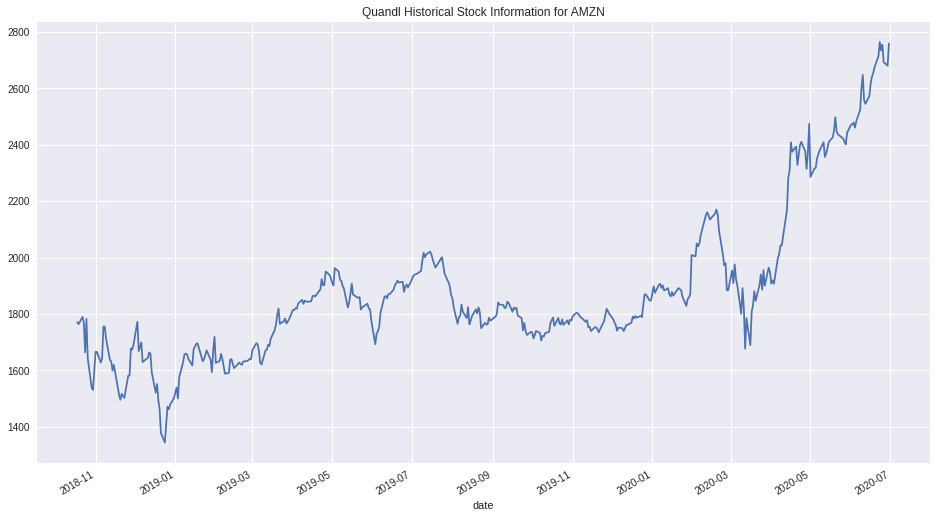

In [12]:
title_string = 'Quandl Historical Stock Information for ' + stock_symbol
stock_quandl['close'].plot(figsize=(16,9), title=title_string)
plt.show()

## Task 3. Develop Strategy and Train Model

### 3.a) Set up the Dataframe for the Trading Model

In [13]:
# Set up the standard column name for modeling
model_template = stock_quandl.loc[:, ['open','close']]
model_template.rename(columns={'open': 'open_price', 'close': 'close_price'}, inplace=True)
if verbose: model_template.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 2018-10-18 to 2020-06-30
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   427 non-null    float64
 1   close_price  427 non-null    float64
dtypes: float64(2)
memory usage: 10.0 KB


### 3.b) Set up the Analysis Table with Indicators

In [14]:
def trading_ma_crossover(model):
    waitfor_first_entry = True
    for x in range(len(model)):
        if model['ma_change'].iloc[x] > 0:
            model['trade_signal'].iloc[x] = 1  # trade_signal = 1 means we should take a long position
        else:
            model['trade_signal'].iloc[x] = 0  # trade_signal = 0 means we should take a flat position
        if x != 0:
            model['signal_change'].iloc[x] = model['trade_signal'].iloc[x] - model['trade_signal'].iloc[x-1]
            if waitfor_first_entry and (model['signal_change'].iloc[x-1] == 1):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
                waitfor_first_entry = False
            elif (not waitfor_first_entry) and (model['signal_change'].iloc[x-1] != 0):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]

In [15]:
model_collection = {}
serial_number = 1

for slow_ma in range(slow_ma_min, slow_ma_max+1, ma_increment):
    for fast_ma in range(fast_ma_min, fast_ma_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        print('Processing model with slow_ma of', slow_ma, 'and fast_ma of', fast_ma)
        model_name = 'SMA_' + str(serial_number).zfill(3) + '_SlowMA_' + str(slow_ma).zfill(2) + '_FastMA_' + str(fast_ma).zfill(2)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        trading_model['fast_ma'] = trading_model['close_price'].rolling(fast_ma).mean()
        trading_model['slow_ma'] = trading_model['close_price'].rolling(slow_ma).mean()
        trading_model['ma_change'] = trading_model['fast_ma'] - trading_model['slow_ma']
        trading_model['trade_signal'] = np.zeros(len(trading_model))
        trading_model['signal_change'] = np.zeros(len(trading_model))
        trading_model['entry_exit'] = np.zeros(len(trading_model))
        trading_model = trading_model[model_start_date:model_end_date]
        trading_ma_crossover(trading_model)
        model_collection[model_name] = trading_model.copy()
        print('Model', model_name, 'added to the trading model collection.')

Processing model with slow_ma of 10 and fast_ma of 5
Model SMA_001_SlowMA_10_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 15 and fast_ma of 5
Model SMA_002_SlowMA_15_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 15 and fast_ma of 10
Model SMA_003_SlowMA_15_FastMA_10 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 5
Model SMA_004_SlowMA_20_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 10
Model SMA_005_SlowMA_20_FastMA_10 added to the trading model collection.
Processing model with slow_ma of 20 and fast_ma of 15
Model SMA_006_SlowMA_20_FastMA_15 added to the trading model collection.
Processing model with slow_ma of 25 and fast_ma of 5
Model SMA_007_SlowMA_25_FastMA_05 added to the trading model collection.
Processing model with slow_ma of 25 and fast_ma of 10
Model SMA_008_SlowMA_25_FastMA_10 added to the trading model 

In [16]:
# List the entry/exit points for each model
for key in model_collection:
    print('List the signal change and entry/exit points for', key)
    if verbose: print(model_collection[key][(model_collection[key].signal_change != 0) | (model_collection[key].entry_exit != 0)])
    else: print(model_collection[key][model_collection[key].entry_exit != 0])
    print()

List the signal change and entry/exit points for SMA_001_SlowMA_10_FastMA_05
            open_price  close_price   fast_ma   slow_ma  ma_change  \
date                                                                 
2019-01-25     1670.50      1670.57  1658.778  1660.322     -1.544   
2019-02-04     1623.00      1633.31  1648.516  1647.816      0.700   
2019-02-05     1643.34      1658.81  1661.502  1650.480     11.022   
2019-02-07     1625.00      1614.37  1634.596  1646.448    -11.852   
2019-02-08     1586.00      1588.22  1626.994  1638.213    -11.219   
2019-02-19     1601.00      1627.58  1627.238  1622.885      4.353   
2019-02-20     1630.00      1622.10  1624.056  1619.214      4.842   
2019-03-11     1626.12      1670.62  1655.750  1656.397     -0.647   
2019-03-12     1669.00      1673.10  1651.884  1660.067     -8.183   
2019-03-15     1703.00      1712.36  1686.622  1673.741     12.881   
2019-03-18     1712.70      1742.15  1700.928  1678.339     22.589   
2019-03-29   

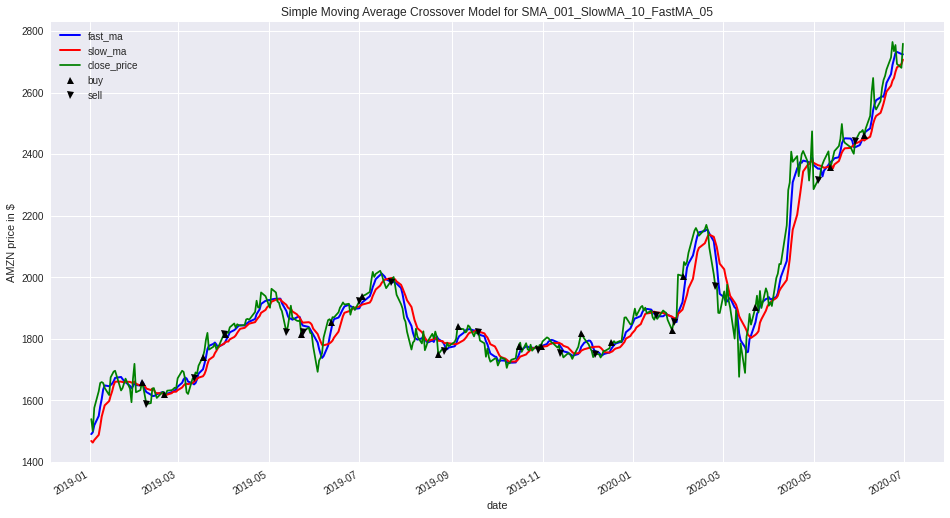

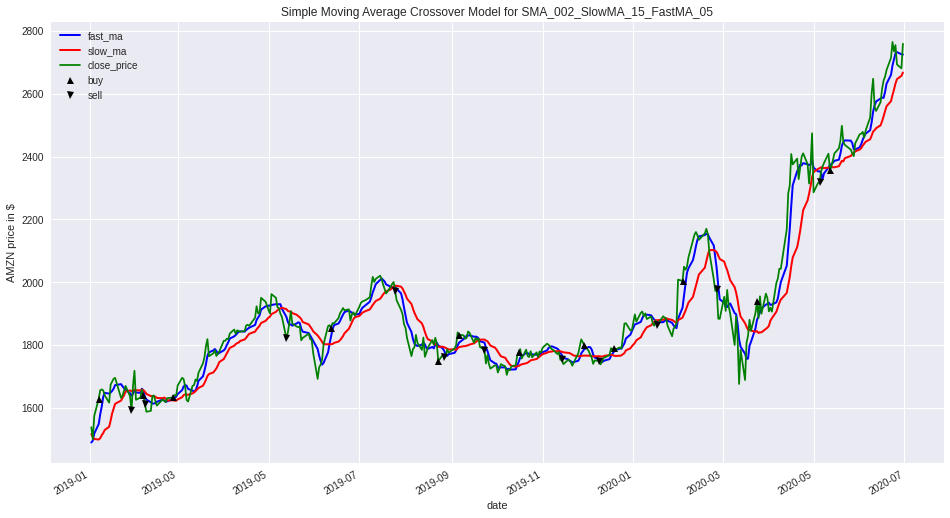

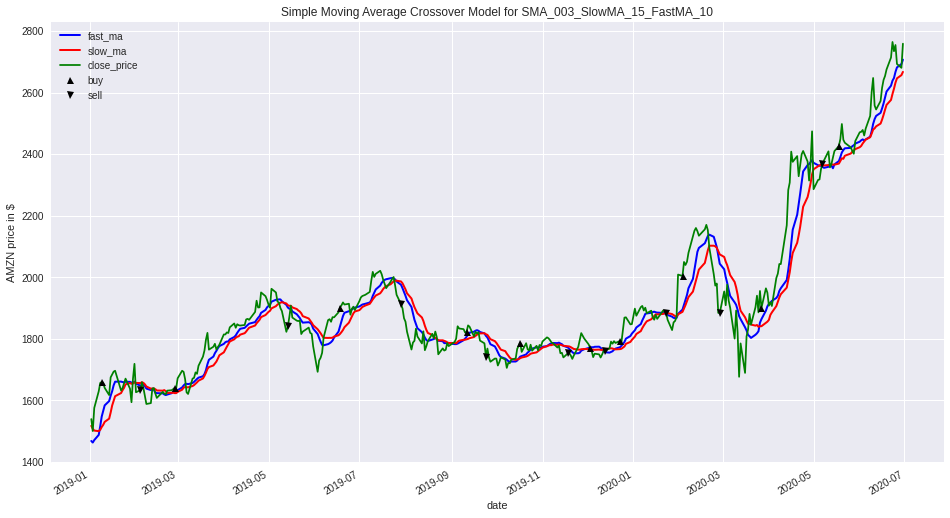

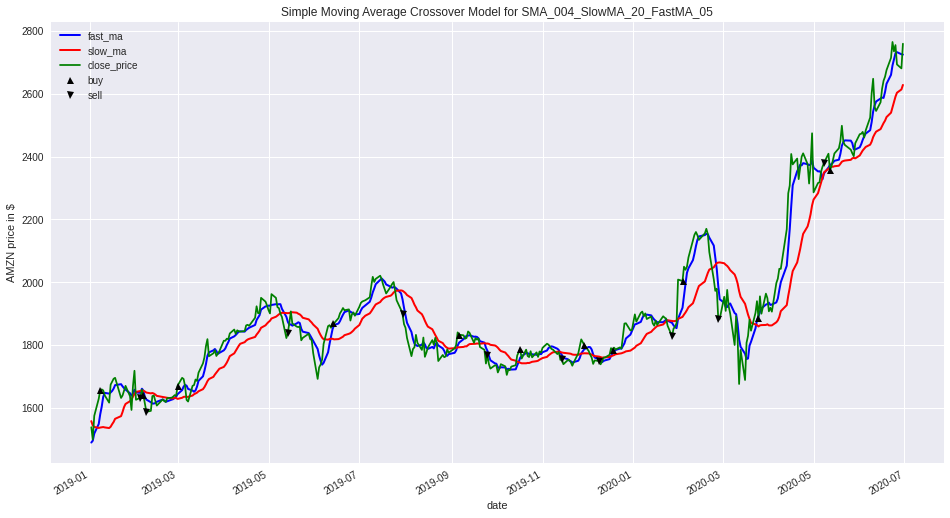

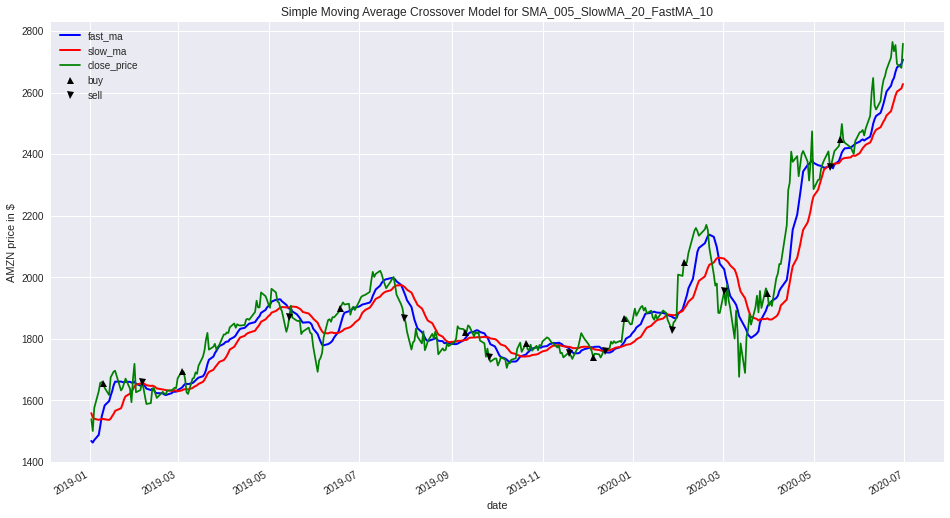

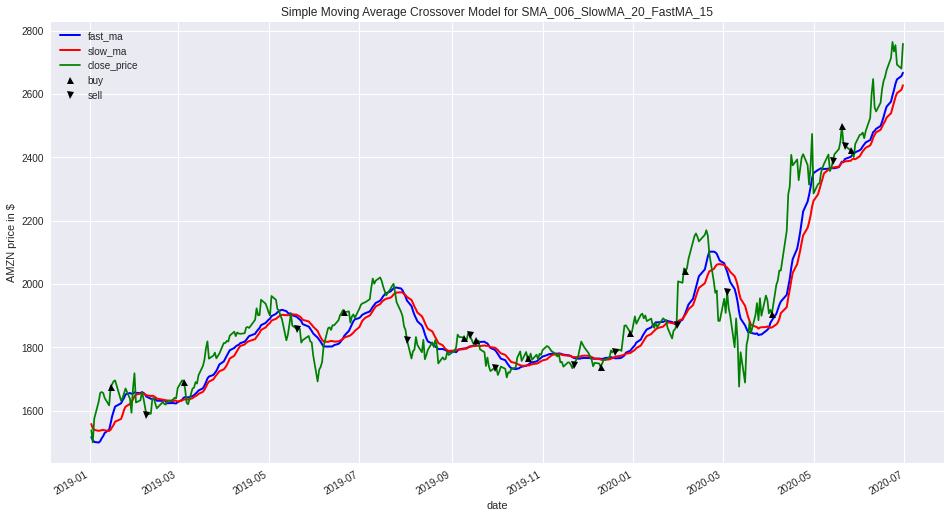

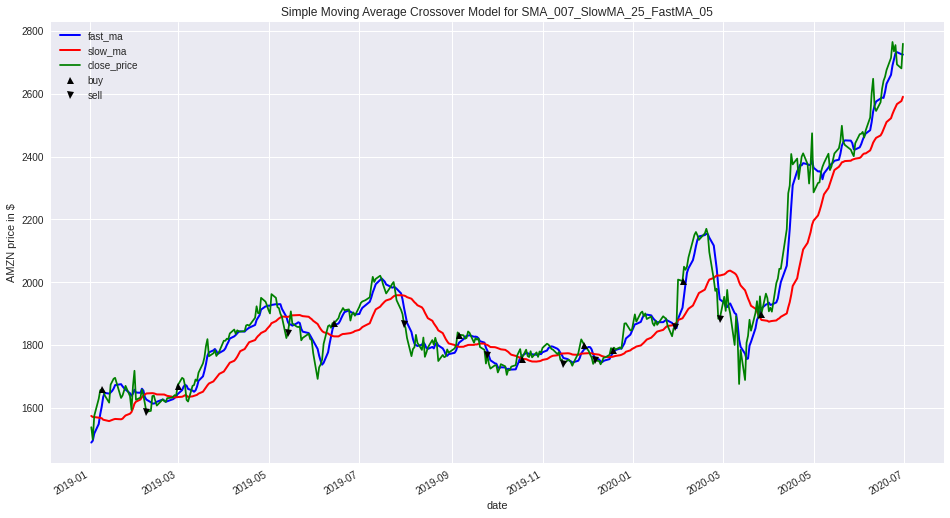

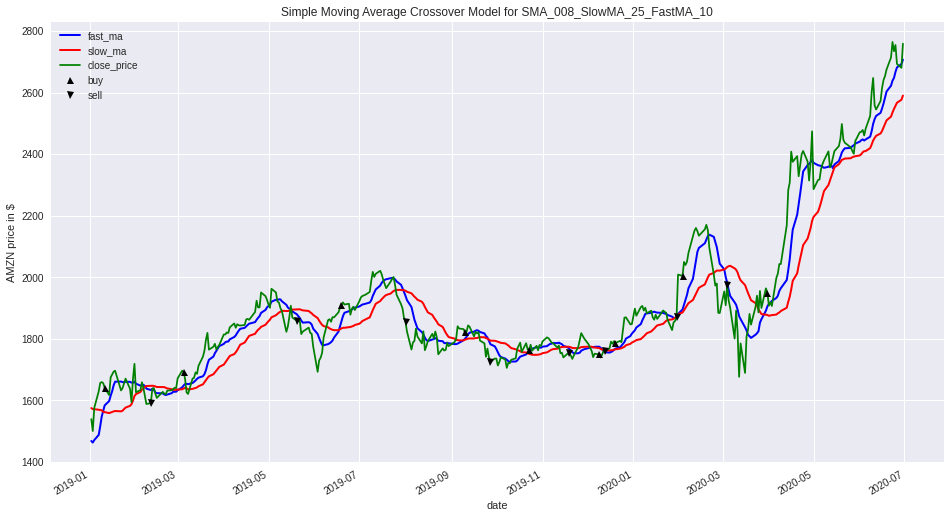

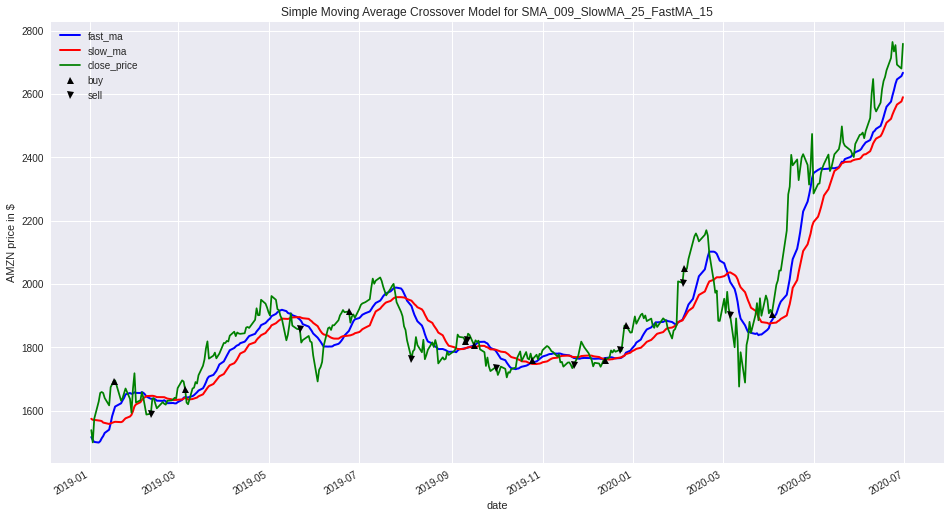

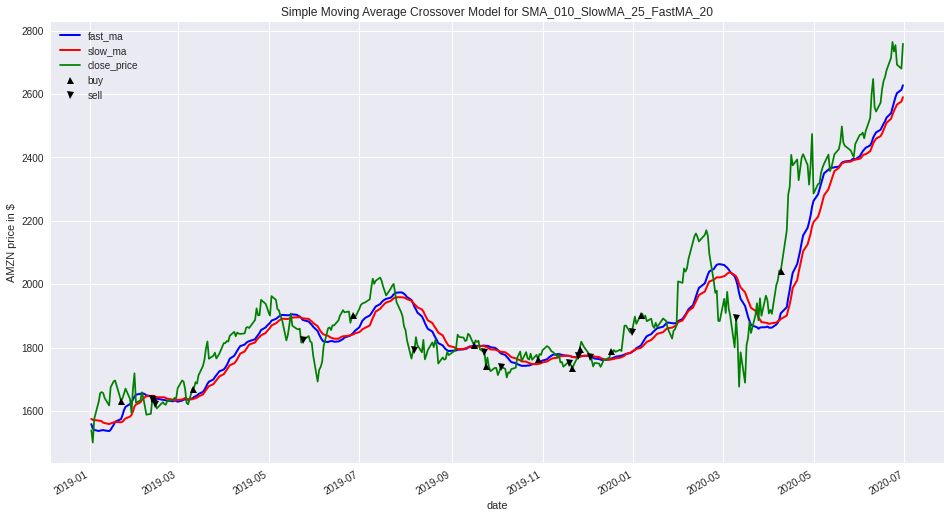

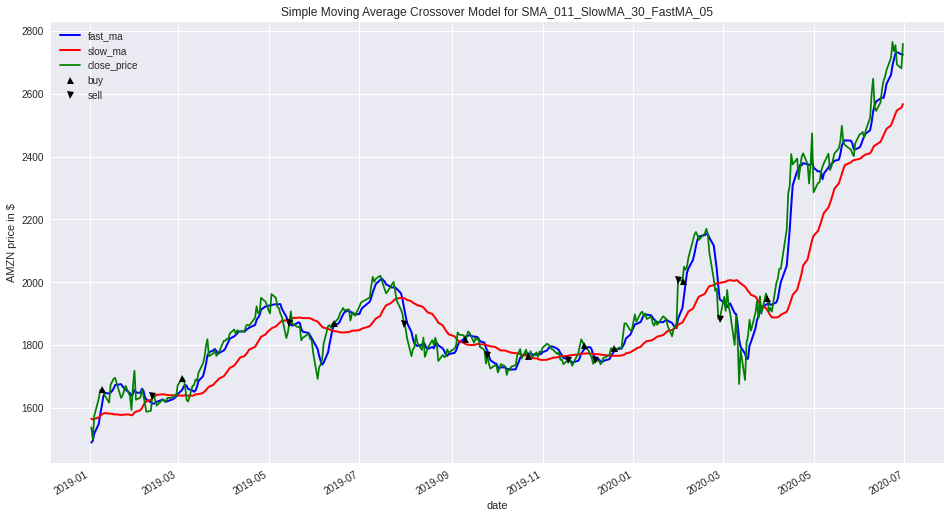

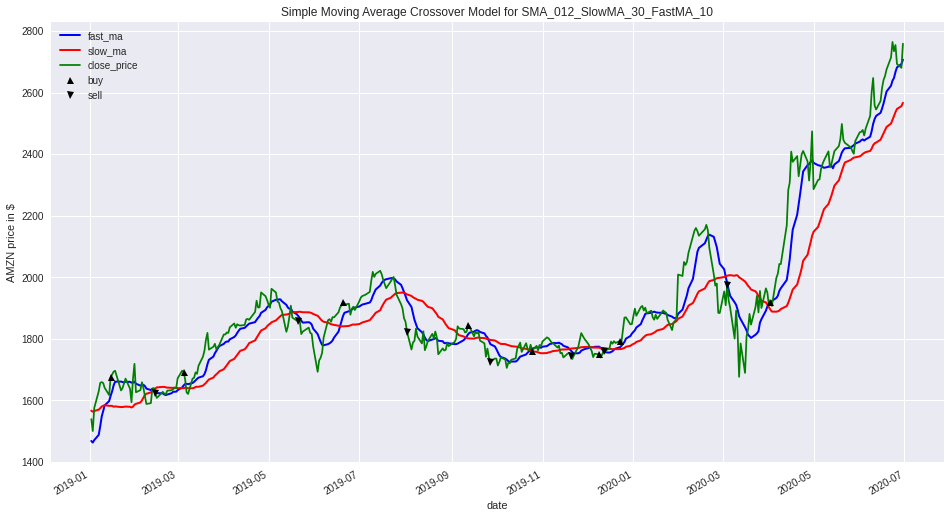

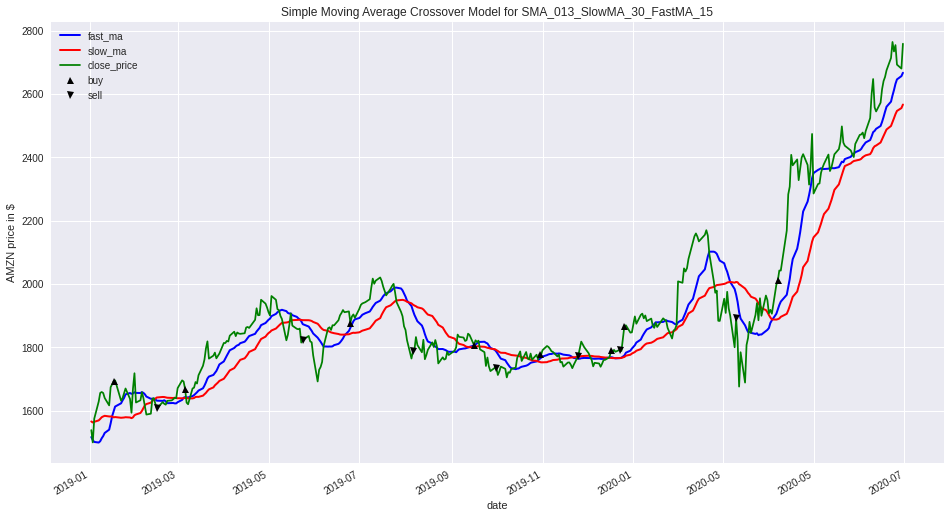

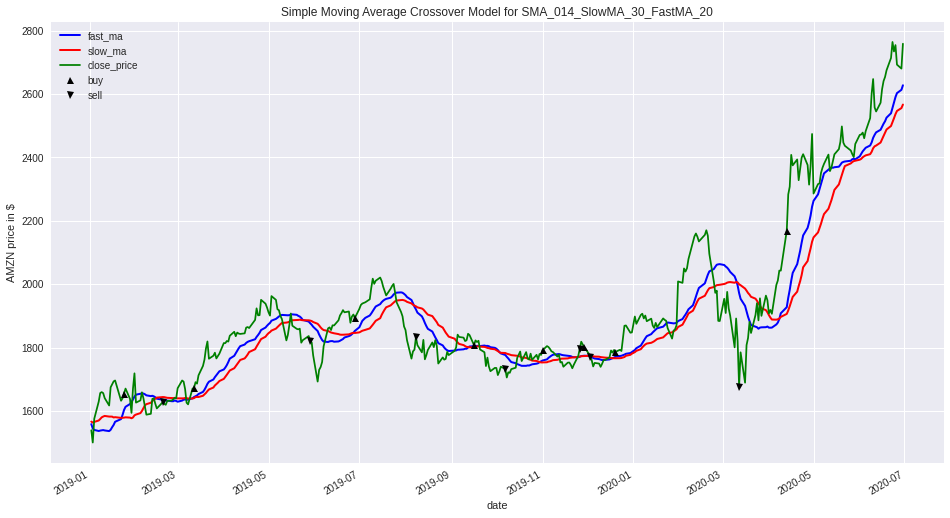

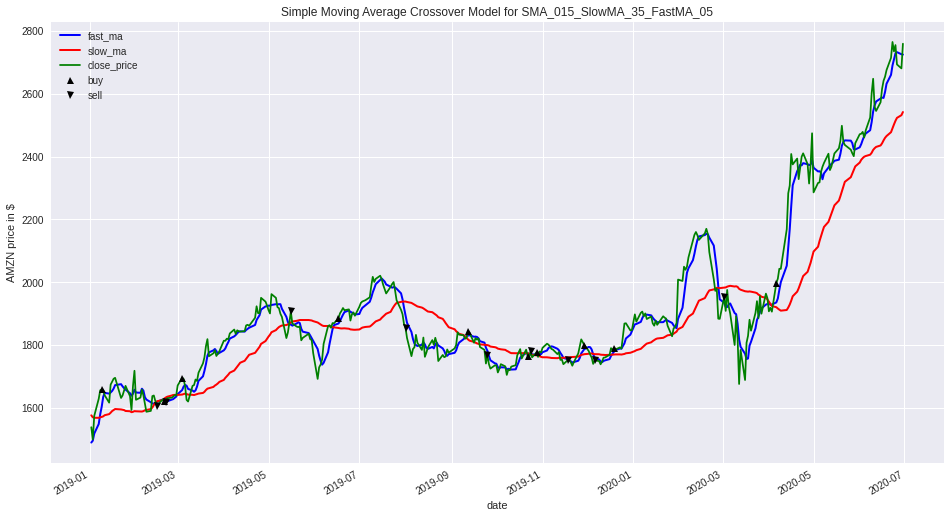

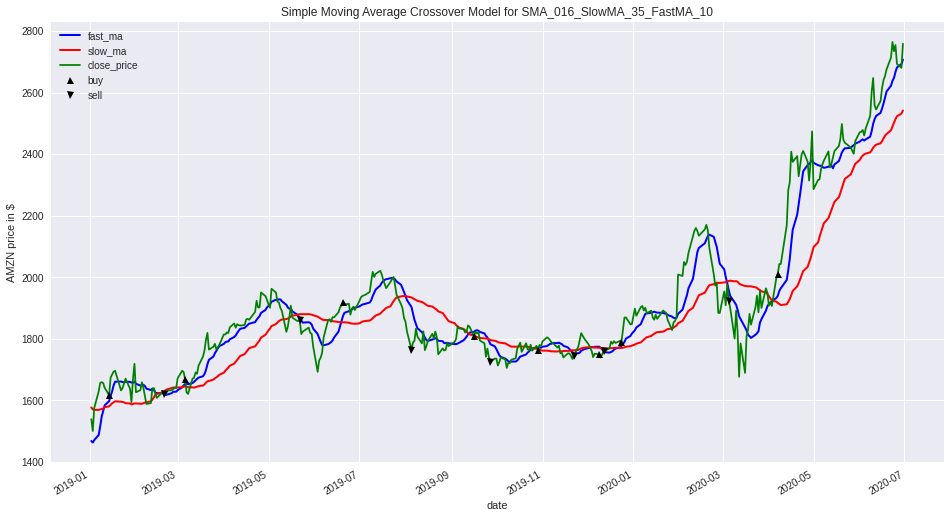

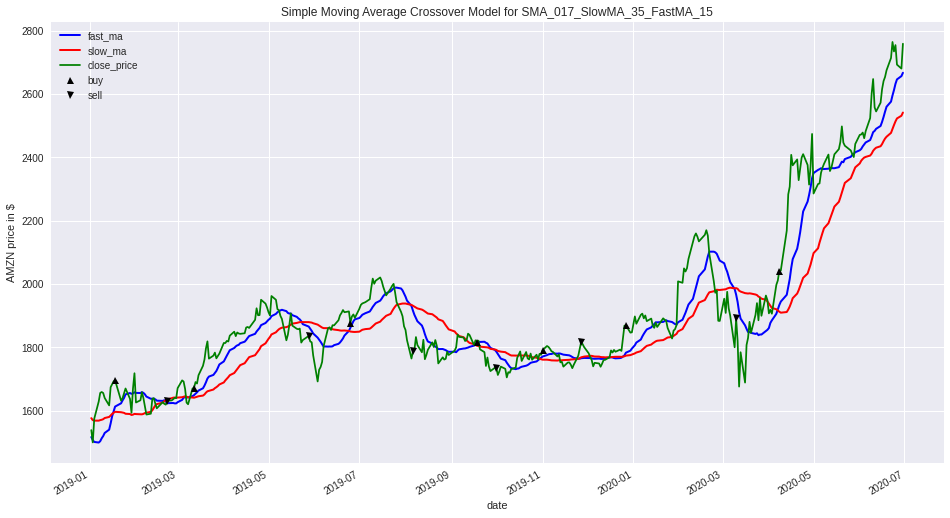

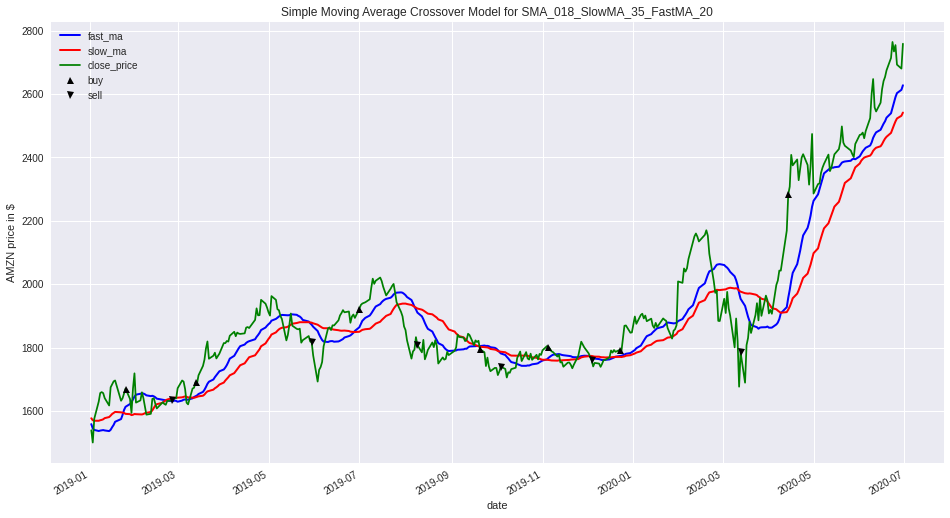

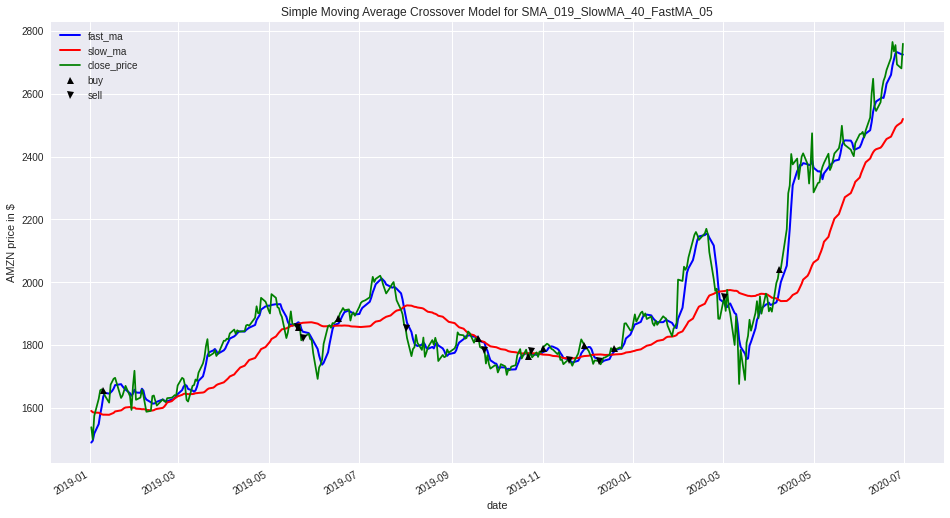

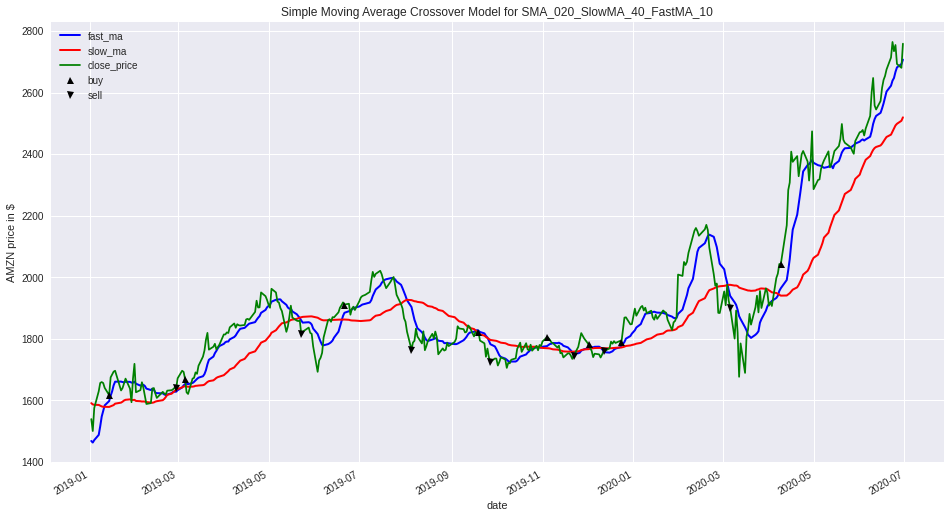

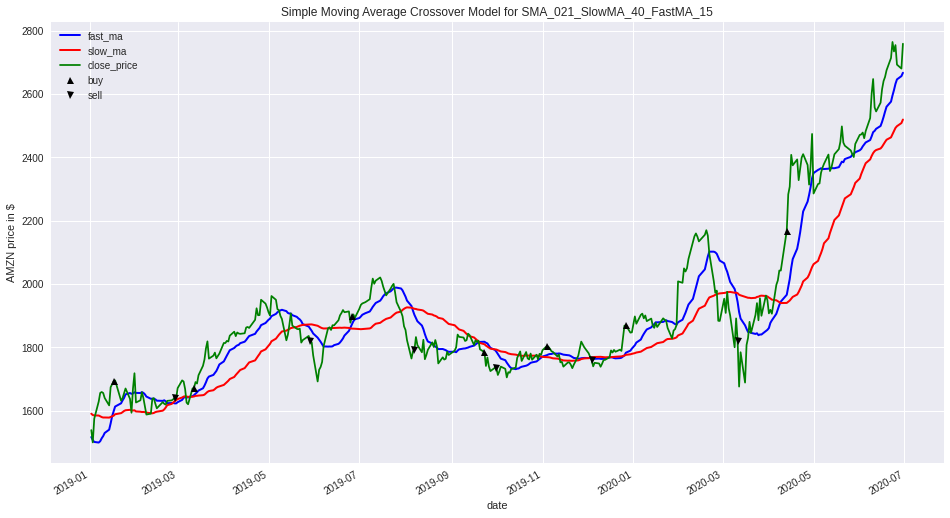

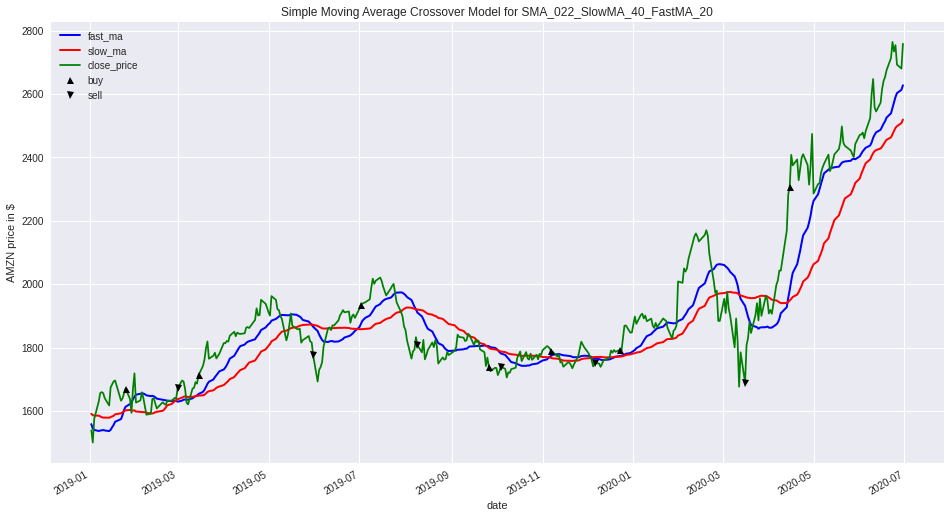

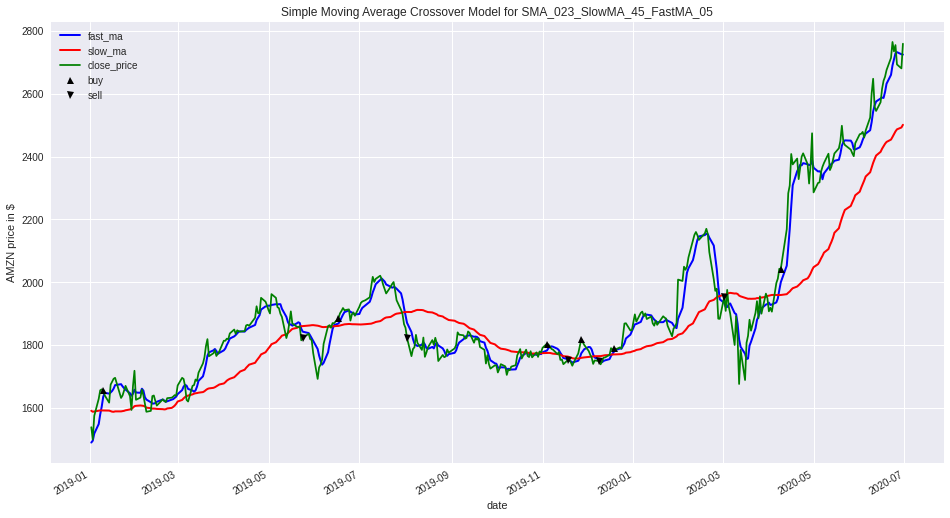

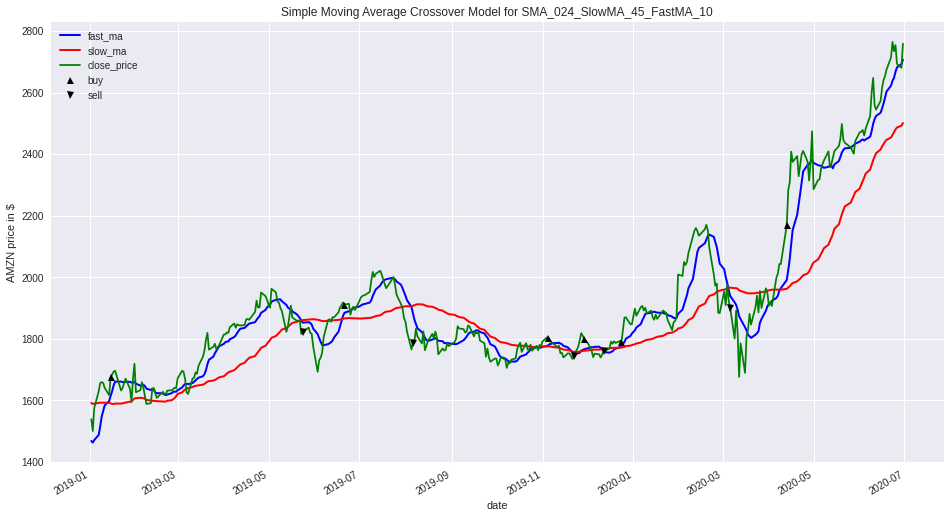

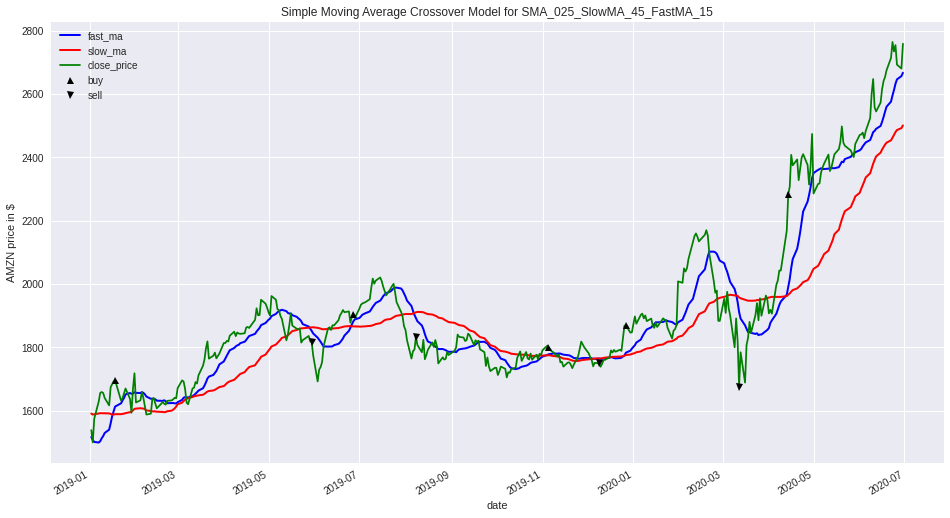

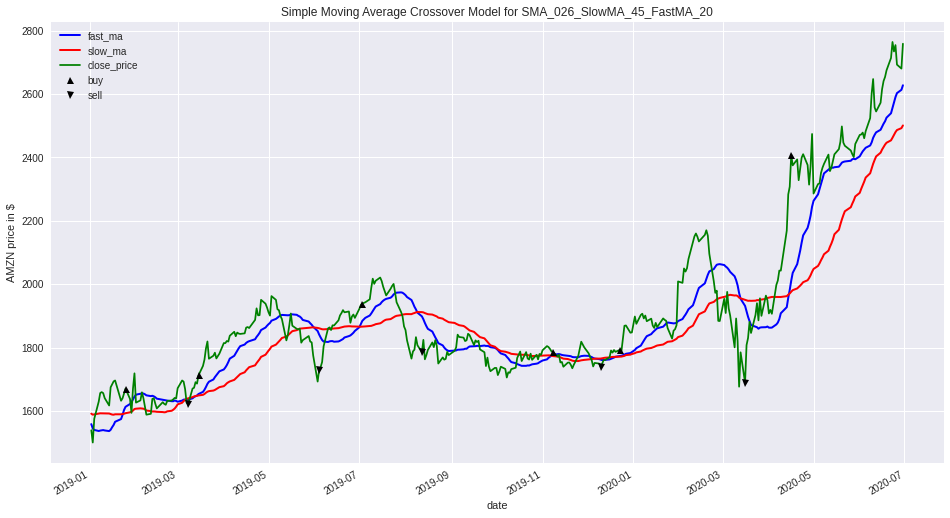

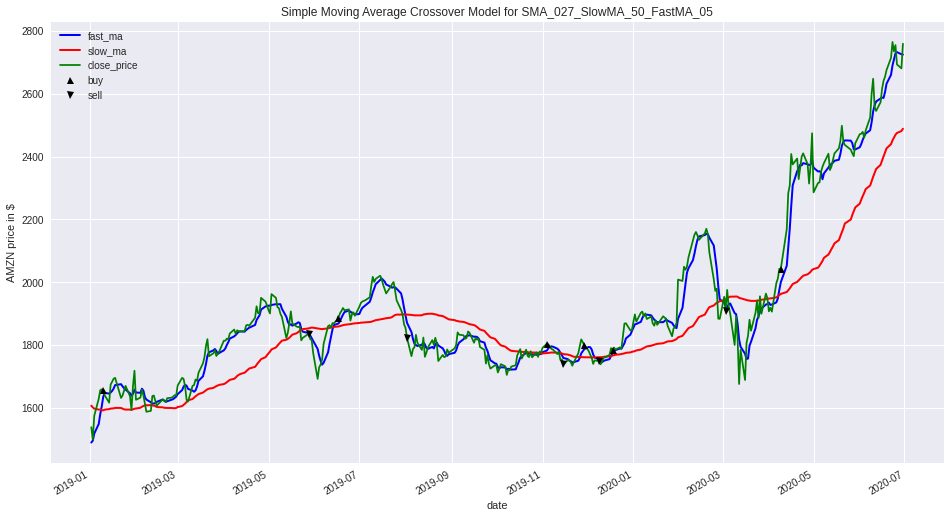

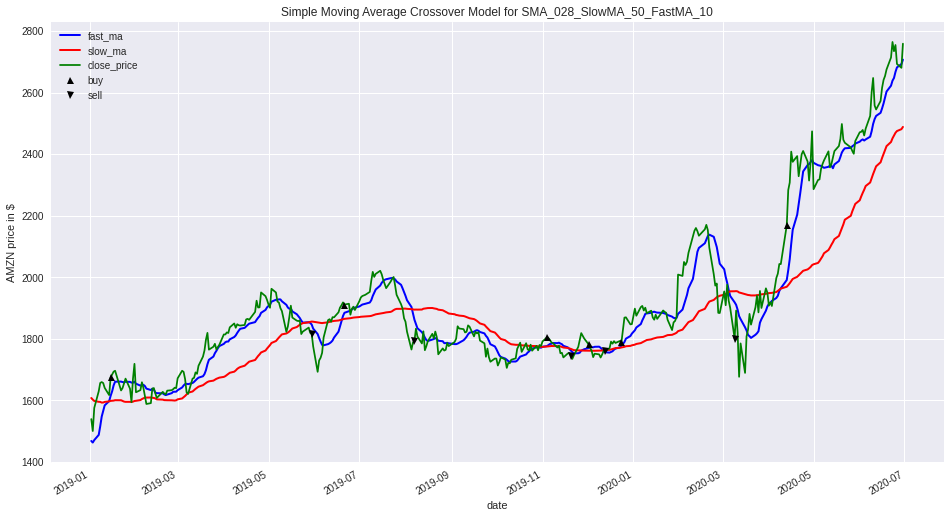

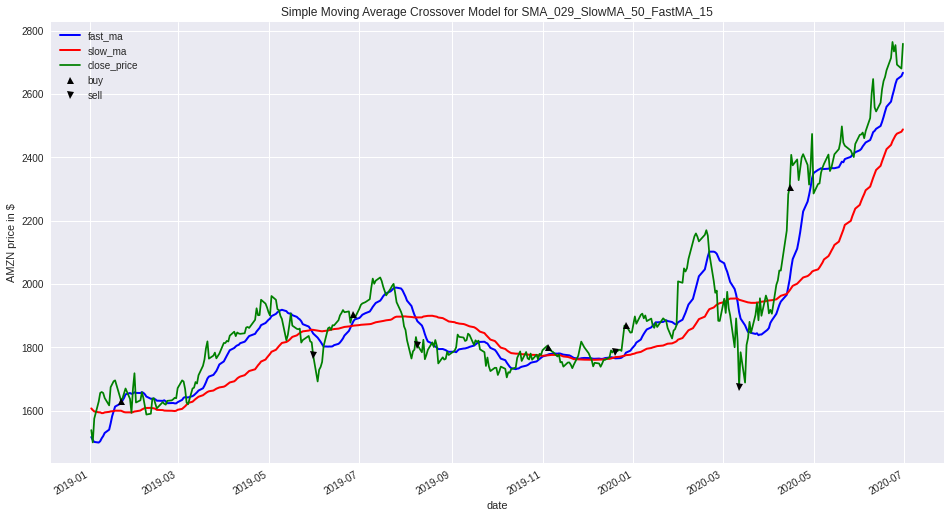

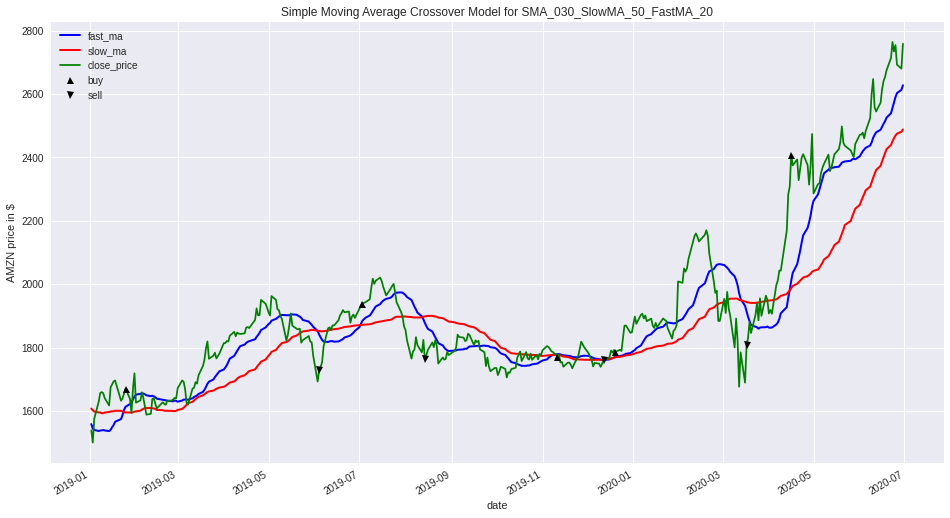

In [17]:
if verbose:
    for key in model_collection:
        graph_data = model_collection[key].copy()
        title_string = "Simple Moving Average Crossover Model for " + key
        fig = plt.figure(figsize=(16,9))
        ylabel = stock_symbol + ' price in $'
        ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
        graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
        graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
        graph_data['close_price'].plot(ax=ax1, color='g')
        ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
        ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
        plt.legend(loc='upper left')
        plt.show()

## Task 4. Back-test Model

In [18]:
def trading_portfolio_generation(initial_fund, trading_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = initial_capital
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = initial_capital
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_fund
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trading_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
        elif (trading_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_fund

    return portfolio

In [19]:
portfolio_collection = {}

# Build dataframe for reporting model performance summary
performance_summary = pd.DataFrame(columns=['model_name','return_value','return_percent'])

for key in model_collection:
    print('Processing portfolio for model:', key)
    portfolio_collection[key] = trading_portfolio_generation(initial_capital, model_collection[key])
    trade_transactions = portfolio_collection[key][portfolio_collection[key].trade_action != 0]
    print(trade_transactions)
    print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (initial_capital, portfolio_collection[key].accumu_return[-1]))
    if initial_capital != 0:
        return_percentage = portfolio_collection[key].accumu_return[-1] / initial_capital * 100
        print('Accumulated return percentage based on the initial capital investment: %.2f%%' % (return_percentage))
    else:
        return_percentage = None
    if trade_transactions.iloc[-1]['trade_action'] == 1:
        print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1], '\n')
    else:
        print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1], '\n')
    performance_summary = performance_summary.append({'model_name': key, 'return_value': portfolio_collection[key].accumu_return[-1],
                                                      'return_percent': return_percentage}, ignore_index=True)

Processing portfolio for model: SMA_001_SlowMA_10_FastMA_05
BOUGHT QTY: 1 on 2019-02-05 00:00:00 at the price of 1643.34
SOLD QTY: -1 on 2019-02-08 00:00:00 at the price of 1586.0
BOUGHT QTY: 1 on 2019-02-20 00:00:00 at the price of 1630.0
SOLD QTY: -1 on 2019-03-12 00:00:00 at the price of 1669.0
BOUGHT QTY: 1 on 2019-03-18 00:00:00 at the price of 1712.7
SOLD QTY: -1 on 2019-04-01 00:00:00 at the price of 1800.11
BOUGHT QTY: 1 on 2019-04-02 00:00:00 at the price of 1811.02
SOLD QTY: -1 on 2019-05-13 00:00:00 at the price of 1836.56
BOUGHT QTY: 1 on 2019-05-23 00:00:00 at the price of 1836.59
SOLD QTY: -1 on 2019-05-24 00:00:00 at the price of 1835.89
BOUGHT QTY: 1 on 2019-06-12 00:00:00 at the price of 1853.98
SOLD QTY: -1 on 2019-07-01 00:00:00 at the price of 1922.98
BOUGHT QTY: 1 on 2019-07-03 00:00:00 at the price of 1935.89
SOLD QTY: -1 on 2019-07-22 00:00:00 at the price of 1971.14
BOUGHT QTY: 1 on 2019-08-23 00:00:00 at the price of 1793.03
SOLD QTY: -1 on 2019-08-27 00:00:00 

In [20]:
# Display the model performance summary
performance_summary.sort_values(by=['return_value'], inplace=True, ascending=False)
print(performance_summary)

                     model_name  return_value return_percent
11  SMA_012_SlowMA_30_FastMA_10       1052.87           None
0   SMA_001_SlowMA_10_FastMA_05        984.42           None
1   SMA_002_SlowMA_15_FastMA_05        973.30           None
26  SMA_027_SlowMA_50_FastMA_05        947.10           None
14  SMA_015_SlowMA_35_FastMA_05        926.03           None
22  SMA_023_SlowMA_45_FastMA_05        890.91           None
18  SMA_019_SlowMA_40_FastMA_05        872.59           None
2   SMA_003_SlowMA_15_FastMA_10        836.41           None
10  SMA_011_SlowMA_30_FastMA_05        805.73           None
7   SMA_008_SlowMA_25_FastMA_10        798.15           None
15  SMA_016_SlowMA_35_FastMA_10        776.13           None
4   SMA_005_SlowMA_20_FastMA_10        743.00           None
23  SMA_024_SlowMA_45_FastMA_10        742.11           None
8   SMA_009_SlowMA_25_FastMA_15        730.92           None
12  SMA_013_SlowMA_30_FastMA_15        706.11           None
6   SMA_007_SlowMA_25_Fa

In [21]:
# Display the transactions from the top model
top_model = performance_summary.iloc[0]['model_name']
print('The transactions from the top model %s:' % (top_model))
print(portfolio_collection[top_model][portfolio_collection[top_model].trade_action != 0])

The transactions from the top model SMA_012_SlowMA_30_FastMA_10:
           trade_action qty_onhand cost_basis sold_transaction gain_loss  \
date                                                                       
2019-01-15            1          1       1632                0         0   
2019-02-14           -1          0          0           1624.5      -7.5   
2019-03-05            1          1    1702.95                0         0   
2019-05-21           -1          0          0          1874.79    171.84   
2019-06-20            1          1    1933.33                0         0   
2019-08-02           -1          0          0          1845.07    -88.26   
2019-09-12            1          1    1837.63                0         0   
2019-09-27           -1          0          0             1748    -89.63   
2019-10-25            1          1    1697.55                0         0   
2019-11-20           -1          0          0          1749.14     51.59   
2019-12-09            1

In [22]:
# Display the entry and exit signals for the top model
print('The trading signal changes from the top model %s:' % (top_model))
print(model_collection[top_model][model_collection[top_model].signal_change != 0])

The trading signal changes from the top model SMA_012_SlowMA_30_FastMA_10:
            open_price  close_price   fast_ma      slow_ma  ma_change  \
date                                                                    
2019-01-14     1615.00      1617.21  1597.627  1582.248667  15.378333   
2019-02-13     1647.00      1640.00  1634.894  1635.696333  -0.802333   
2019-03-04     1685.00      1696.17  1641.890  1639.817667   2.072333   
2019-05-20     1852.69      1858.97  1879.811  1886.956667  -7.145667   
2019-06-19     1907.84      1908.79  1857.420  1840.501000  16.919000   
2019-08-01     1871.72      1855.32  1939.540  1947.404333  -7.864333   
2019-09-11     1812.14      1822.99  1806.652  1802.218667   4.433333   
2019-09-26     1762.79      1739.84  1793.793  1798.121667  -4.328667   
2019-10-24     1771.09      1780.78  1765.249  1761.505000   3.744000   
2019-11-19     1756.99      1752.79  1767.202  1767.411333  -0.209333   
2019-12-06     1751.20      1751.60  1774.014  17

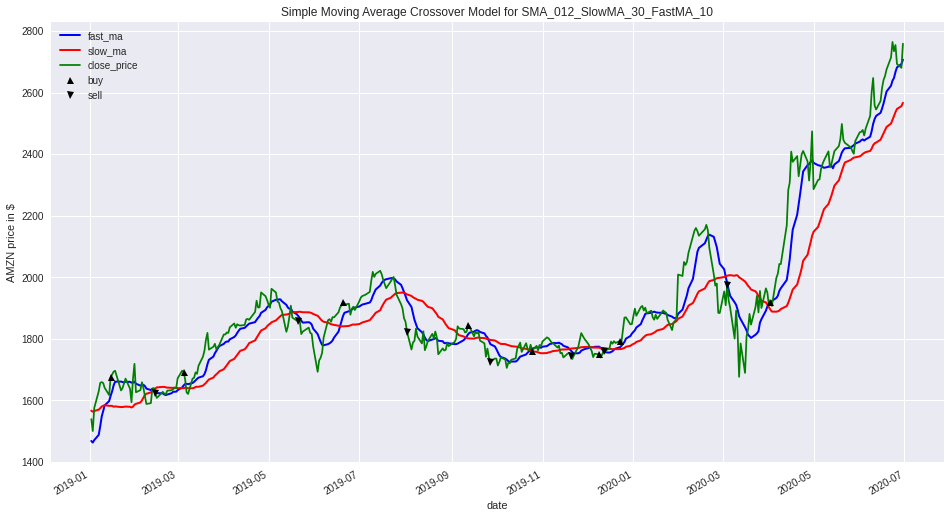

In [23]:
graph_data = model_collection[top_model].copy()
title_string = "Simple Moving Average Crossover Model for " + top_model
fig = plt.figure(figsize=(16,9))
ylabel = stock_symbol + ' price in $'
ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
graph_data['close_price'].plot(ax=ax1, color='g')
ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
plt.legend(loc='upper left')
plt.show()

## Task 5. Evaluate Performance

In [24]:
best_model = ''
best_return = 0
for key in portfolio_collection:
    if portfolio_collection[key]['accumu_return'][-1] > best_return:
        best_model = key
        best_return = portfolio_collection[best_model]['accumu_return'][-1]
print('The best model found is:', best_model)
print('The best profit/loss for the investing period is: $%.2f' % (best_return))
if initial_capital != 0:
    print('The best return percentage for initial capital is: %.2f%%' % (best_return / initial_capital * 100))

The best model found is: SMA_012_SlowMA_30_FastMA_10
The best profit/loss for the investing period is: $1052.87


In [25]:
worst_model = None
worst_return = 0
for key in portfolio_collection:
    if portfolio_collection[key]['accumu_return'][-1] < worst_return:
        worst_model = key
        worst_return = portfolio_collection[worst_model]['accumu_return'][-1]
print('The worst model found is:', worst_model)
print('The worst profit/loss for the investing period is: $%.2f' % (worst_return))
if initial_capital != 0:
    print('The worst return percentage for the initial capital is: %.2f%%' % (worst_return / initial_capital * 100))

The worst model found is: None
The worst profit/loss for the investing period is: $0.00


In [26]:
# Calculate the stock's performance for a long-only model
model_template = model_template[model_start_date:model_end_date]
print('The performance of the long-only model from day one is: $%.2f' %(model_template.iloc[-1]['close_price'] - model_template.iloc[0]['open_price']))

The performance of the long-only model from day one is: $1293.62


In [27]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:46.075581
